In [49]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [50]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 25

IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_image_generator = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values
    rotation_range=25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'   # cats vs dogs
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# MODIFIED: use validation folder as temporary test set
test_data_gen = test_image_generator.flow_from_directory(
    validation_dir,              # <-- changed from test_dir
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False                # for evaluation
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


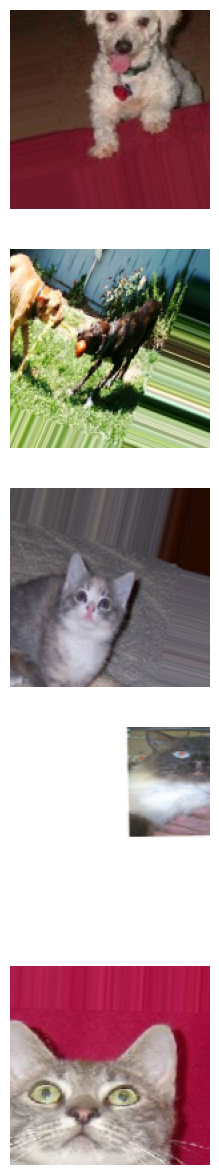

In [52]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [53]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values
    rotation_range=30,         # random rotations
    width_shift_range=0.3,     # horizontal shifts
    height_shift_range=0.2,    # vertical shifts
    shear_range=0.2,           # shear transform
    zoom_range=0.2,            # zoom
    horizontal_flip=True,      # flip images
    fill_mode='nearest'        # filling strategy
)

# Validation generator (just rescaling)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Test generator (just rescaling)
test_image_generator = ImageDataGenerator(rescale=1./255)


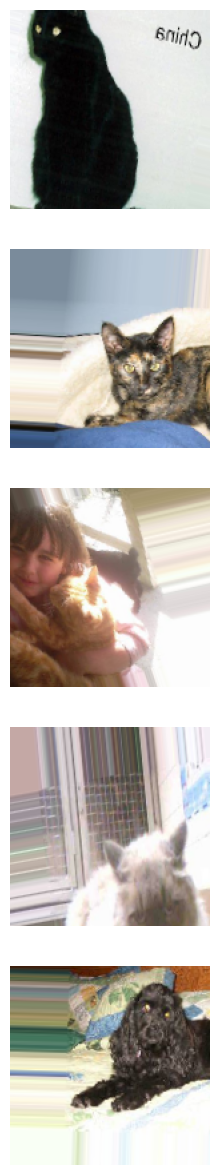

In [54]:
# Get first batch of images
images, labels = next(train_data_gen)   # fetch one batch

# Take first 5 images (these are augmented differently each epoch)
augmented_images = images[:5]

# Plot them
plotImages(augmented_images)


In [55]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Improved CNN model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2,2),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Block 4 (added for deeper features)
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),              # helps prevent overfitting
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - accuracy: 0.5056 - loss: 0.6947 - val_accuracy: 0.5427 - val_loss: 0.6810
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5781 - loss: 0.6862 - val_accuracy: 0.5396 - val_loss: 0.6799
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 452ms/step - accuracy: 0.5528 - loss: 0.6824 - val_accuracy: 0.5979 - val_loss: 0.6578
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4688 - loss: 0.7130 - val_accuracy: 0.5854 - val_loss: 0.6682
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - accuracy: 0.5903 - loss: 0.6666 - val_accuracy: 0.6010 - val_loss: 0.6461
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6250 - loss: 0.6261 - val_accuracy: 0.5271 - val_loss: 0.7081
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5973 - loss: 0.6571 - val_accuracy: 0.5885 - val_loss: 0.6532
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6250 - loss: 0.6708 - val_accuracy: 0.

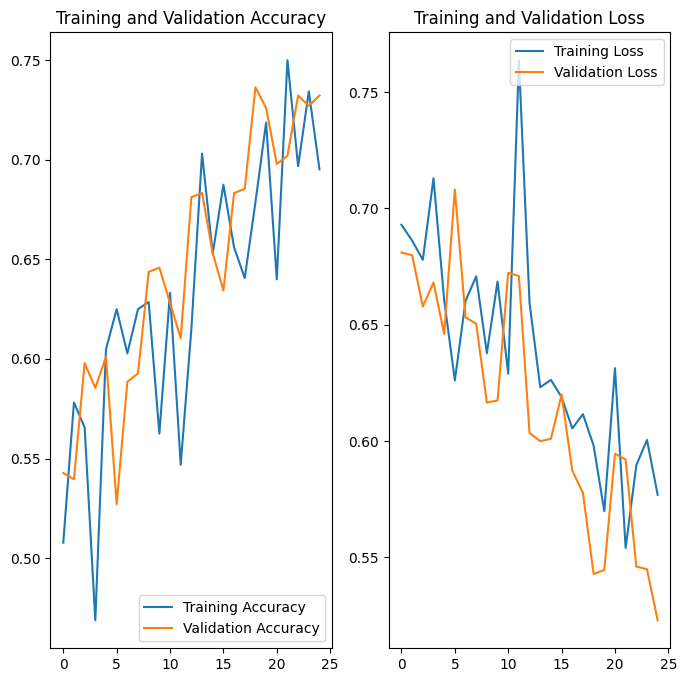

In [57]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
# Predict on test set
probabilities = model.predict(test_data_gen, steps=len(test_data_gen))
probabilities = probabilities.flatten()

# Ground truth labels
answers = test_data_gen.classes

# Calculate percentage
correct = sum(round(p) == a for p, a in zip(probabilities, answers))
percentage_identified = (correct / len(answers)) * 100

print(f"Your model correctly identified {percentage_identified:.2f}% of the images.")

if percentage_identified >= 63:
    print("You passed the challenge! 🎉")
else:
    print("Not yet — need at least 63%. Keep training!")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
Your model correctly identified 72.90% of the images.
You passed the challenge! 🎉


In [59]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 46.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
